<a href="https://colab.research.google.com/github/CristhianSeverino/DataScienceEcomerce/blob/Red-Nuronal/Red_Neuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# Importar librerías
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Input, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')



In [44]:
# 1. Carga y exploración de datos
df = pd.read_csv('net_demand_per_day_stock.csv', parse_dates=['Date'])

print("Primeras filas del dataset:")
print(df.head())
print("\nInformación del dataset:")
print(df.info())
print("\nValores nulos por columna:")
print(df.isnull().sum())


Primeras filas del dataset:
        Date StockCode  Net_Demand
0 2010-12-01     10002          60
1 2010-12-01     10125           2
2 2010-12-01     10133           5
3 2010-12-01     10135           1
4 2010-12-01     11001           3

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280451 entries, 0 to 280450
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Date        280451 non-null  datetime64[ns]
 1   StockCode   280451 non-null  object        
 2   Net_Demand  280451 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 6.4+ MB
None

Valores nulos por columna:
Date          0
StockCode     0
Net_Demand    0
dtype: int64


In [45]:
# 2. Preparación de datos para un producto específico
stock_code_to_predict = '23170'  # Producto de prueba
product_data = df[df['StockCode'] == stock_code_to_predict][['Date', 'Net_Demand']]
product_data = product_data.groupby('Date')['Net_Demand'].sum().reset_index()
product_data = product_data.set_index('Date')

print(f"\nDatos para el producto {stock_code_to_predict}:")
print(product_data.head())
print(f"\nLongitud de product_data: {len(product_data)}")

# Verificar si hay suficientes datos
n_steps = 30
if len(product_data) <= n_steps:
    print(f"Error: No hay suficientes datos para el producto {stock_code_to_predict} "
          f"para crear secuencias de longitud {n_steps}. Longitud: {len(product_data)}")
    exit()


Datos para el producto 23170:
            Net_Demand
Date                  
2011-05-10          86
2011-05-11         133
2011-05-12          72
2011-05-13         192
2011-05-15           9

Longitud de product_data: 158


In [46]:
# 3. Procesamiento de la serie de tiempo
scaler = MinMaxScaler()
product_data['QuantityScaled'] = scaler.fit_transform(product_data[['Net_Demand']])

In [47]:
# 4. Creación de secuencias
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)



In [48]:
# 5. Definir hiperparámetros
n_steps_values = [10, 20, 30]  # Diferentes tamaños de ventana
arquitecturas = [[50], [100, 50]]  # Ejemplo: [50] = 1 capa LSTM, [100, 50] = 2 capas
learning_rates = [0.001, 0.01]
batch_sizes = [32, 64]


In [49]:
# 6. Función para crear y entrenar el modelo
def crear_y_entrenar_modelo(n_steps, arquitectura, learning_rate, batch_size, epochs=50):
    tf.keras.backend.clear_session()  # Limpiar sesión anterior
    tf.random.set_seed(42)  # Reproducibilidad

    model = Sequential()
    model.add(Input(shape=(n_steps, 1)))
    for i, unidades in enumerate(arquitectura):
        if i < len(arquitectura) - 1:
            model.add(LSTM(unidades, activation='relu', return_sequences=True))
            model.add(Dropout(0.2))
        else:
            model.add(LSTM(unidades, activation='relu'))
            model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    print("\nArquitectura del modelo:")
    model.summary()

    history = model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size,
        validation_data=(X_test, y_test), verbose=1
    )
    return model, history

In [50]:
# 7. Función para visualizar resultados
def visualizar_resultados(model, product_data, X_test, y_test, scaler, stock_code):
    predictions = model.predict(X_test, verbose=0)
    predictions = scaler.inverse_transform(predictions)
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(12, 6))
    plt.plot(product_data.index[-len(y_test_original):], y_test_original, label='Real')
    plt.plot(product_data.index[-len(predictions):], predictions, label='Predicciones')
    plt.title(f'Predicción de Demanda para {stock_code}')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda Neta')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'predicciones_{stock_code}.png')
    plt.show()



Procesando n_steps = 10

Experimento: n_steps=10, arquitectura=[50], learning_rate=0.001, batch_size=32

Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - loss: 0.0226 - val_loss: 0.0170
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0165 - val_loss: 0.0122
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0122 - val_loss: 0.0087
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0087 - val_loss: 0.0073
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0091 - val_loss: 0.0082
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0090 - val_loss: 0.0077
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0093 - val_loss: 0.0073
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0084 - val_loss: 0.0072
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0084 - val_loss: 0.0073
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0084 - val_loss: 0.0073
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0085 - val_loss: 0.0072


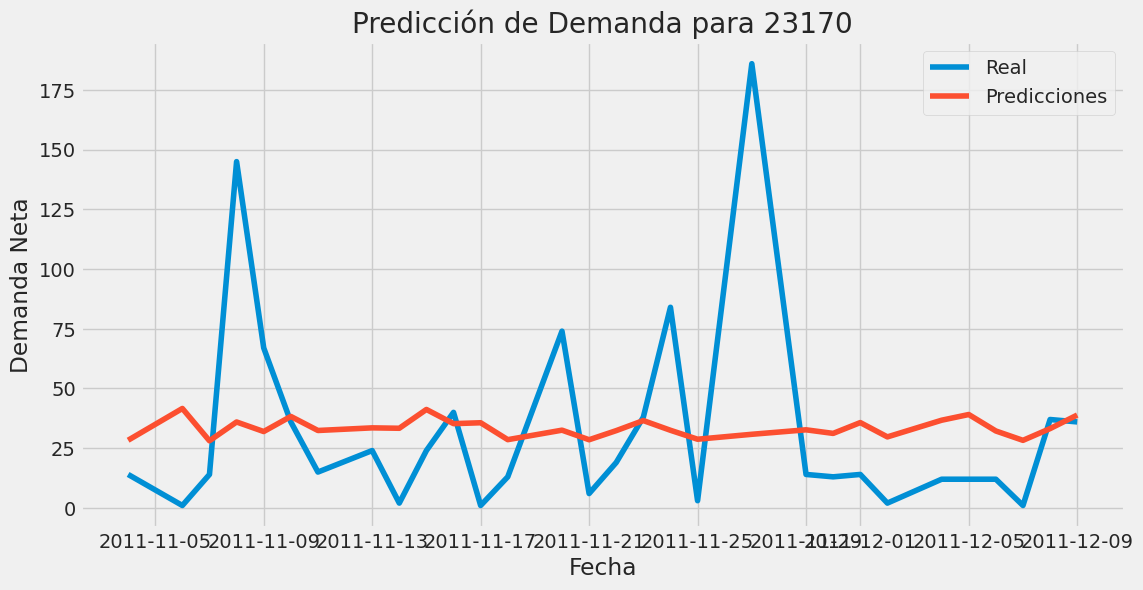


Experimento: n_steps=10, arquitectura=[50], learning_rate=0.001, batch_size=64

Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - loss: 0.0232 - val_loss: 0.0179
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0192 - val_loss: 0.0147
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0157 - val_loss: 0.0120
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0133 - val_loss: 0.0098
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0114 - val_loss: 0.0083
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0104 - val_loss: 0.0075
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0094 - val_loss: 0.0074
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0097 - val_loss: 0.0077
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0098 - val_loss: 0.0081
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0113 - val_loss: 0.0081
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0105 - val_loss: 0.0078
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0103 - val_loss

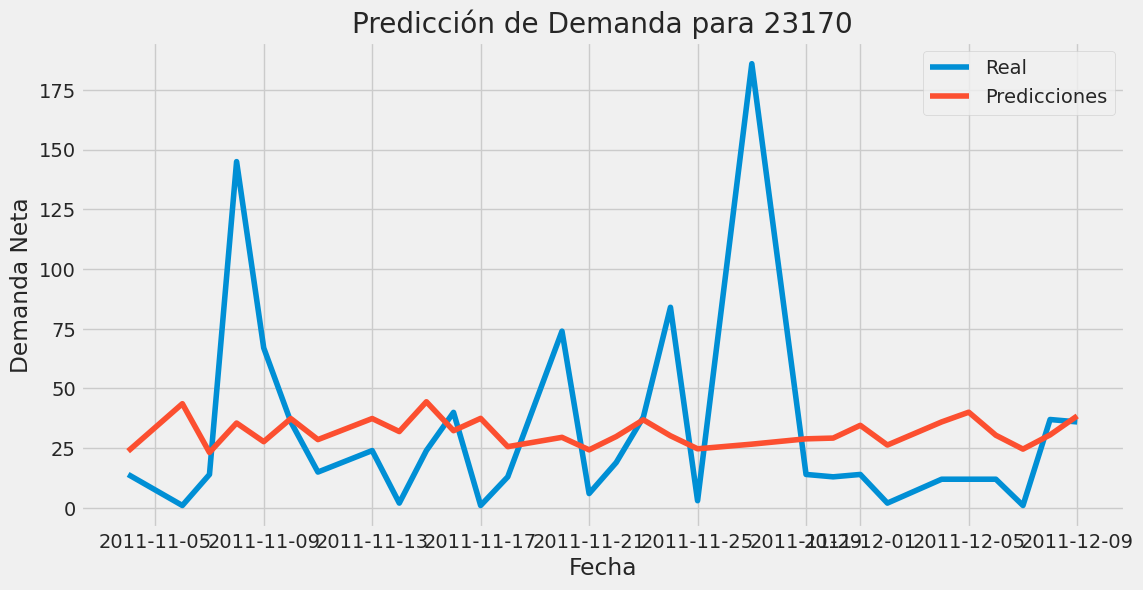


Experimento: n_steps=10, arquitectura=[50], learning_rate=0.01, batch_size=32

Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.0208 - val_loss: 0.0092
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0091 - val_loss: 0.0077
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0084 - val_loss: 0.0072
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0079 - val_loss: 0.0074
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0087 - val_loss: 0.0072
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0083 - val_loss: 0.0072
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0081 - val_loss: 0.0071
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0088 - val_loss: 0.0071
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0077 - val_loss: 0.0070
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0080 - val_loss: 0.0070
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0078 - val_loss: 0.0070


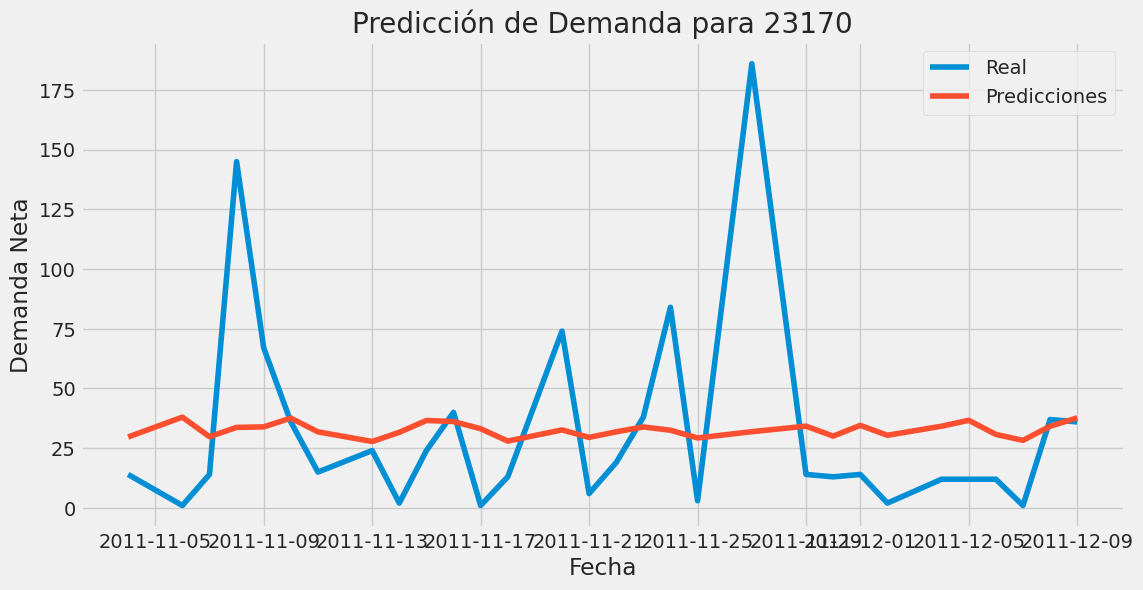


Experimento: n_steps=10, arquitectura=[50], learning_rate=0.01, batch_size=64

Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step - loss: 0.0262 - val_loss: 0.0077
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0101 - val_loss: 0.0126
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0138 - val_loss: 0.0072
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0093 - val_loss: 0.0079
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0098 - val_loss: 0.0082
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0100 - val_loss: 0.0076
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0098 - val_loss: 0.0071
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0091 - val_loss: 0.0071
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0094 - val_loss: 0.0074
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.0090 - val_loss: 0.0074
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0094 - val_loss: 0.0072
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0099 - val_los

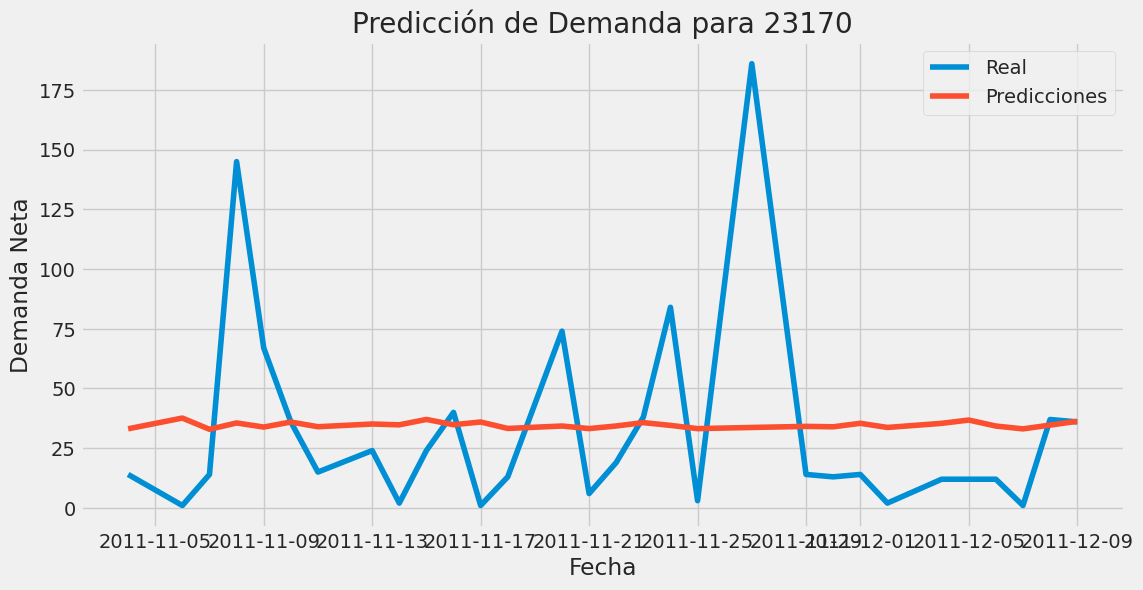


Experimento: n_steps=10, arquitectura=[100, 50], learning_rate=0.001, batch_size=32

Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 324ms/step - loss: 0.0302 - val_loss: 0.0225
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0219 - val_loss: 0.0147
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0140 - val_loss: 0.0084
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0091 - val_loss: 0.0077
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0090 - val_loss: 0.0073
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0080 - val_loss: 0.0072
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0079 - val_loss: 0.0074
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0085 - val_loss: 0.0073
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0083 - val_loss: 0.0071
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0082 - val_loss: 0.0072

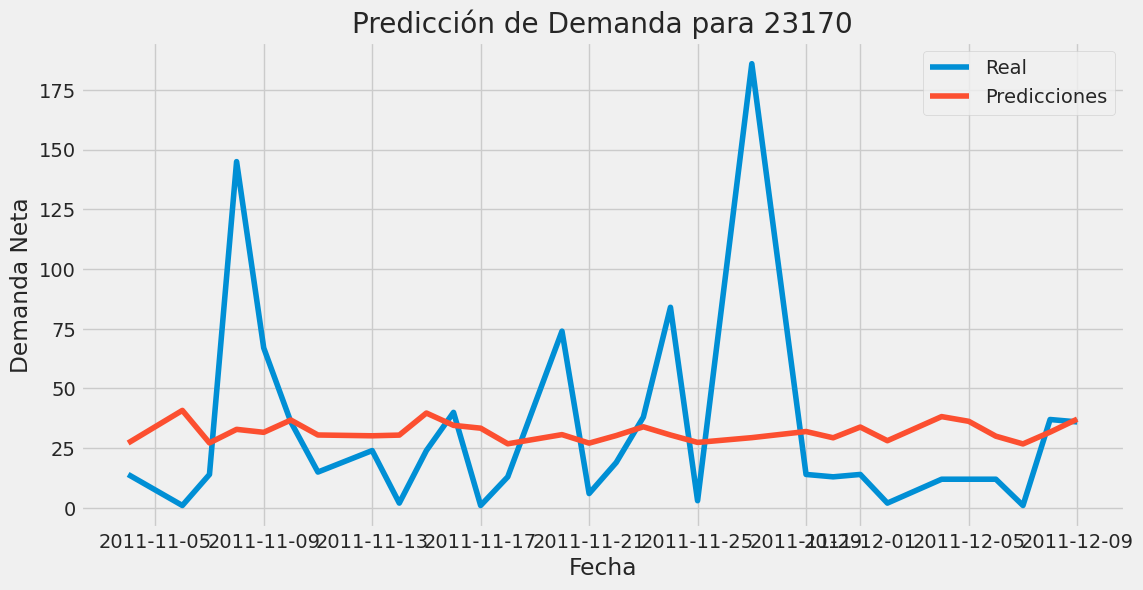


Experimento: n_steps=10, arquitectura=[100, 50], learning_rate=0.001, batch_size=64

Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 660ms/step - loss: 0.0342 - val_loss: 0.0263
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0280 - val_loss: 0.0212
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0226 - val_loss: 0.0167
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0184 - val_loss: 0.0125
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0143 - val_loss: 0.0092
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.0104 - val_loss: 0.0072
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0091 - val_loss: 0.0075
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0097 - val_loss: 0.0089
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0112 - val_loss: 0.0090
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0108 - val_loss: 0.0082
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.0100 - val_loss: 0.0074
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 0.0099 - val_lo

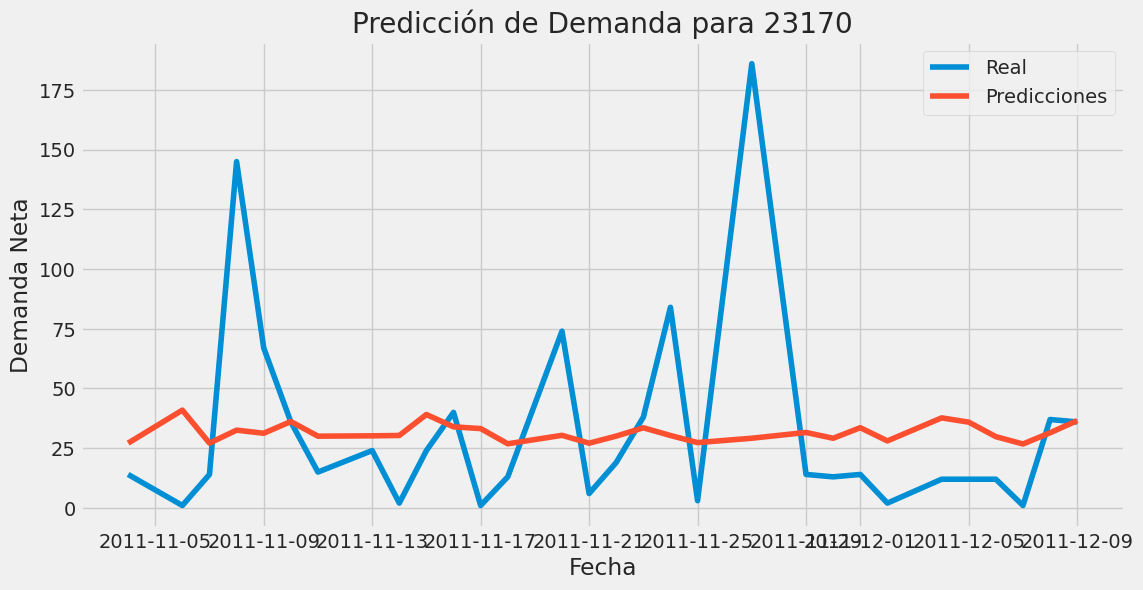


Experimento: n_steps=10, arquitectura=[100, 50], learning_rate=0.01, batch_size=32

Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - loss: 0.0236 - val_loss: 0.0071
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0080 - val_loss: 0.0071
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0081 - val_loss: 0.0073
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0082 - val_loss: 0.0070
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0078 - val_loss: 0.0070
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0081 - val_loss: 0.0070
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0082 - val_loss: 0.0070
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0081 - val_loss: 0.0070
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0083 - val_loss: 0.0070
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0081 - val_loss: 0.0070
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0080 - val_loss: 0.0070


In [ ]:
# 8. Bucle principal para experimentar con hiperparámetros
for n_steps in n_steps_values:
    print(f"\nProcesando n_steps = {n_steps}")
    X, y = create_sequences(product_data['QuantityScaled'].values, n_steps)

    # Dividir datos con train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Verificar que los conjuntos no estén vacíos
    if len(X_train) == 0 or len(X_test) == 0:
        print(f"Error: No hay suficientes datos para n_steps = {n_steps}. Longitud X: {len(X)}. Skipping...")
        continue

    # Reshape para LSTM (n_samples, n_steps, n_features)
    X_train = X_train.reshape((X_train.shape[0], n_steps, 1))
    X_test = X_test.reshape((X_test.shape[0], n_steps, 1))

    # Probar diferentes combinaciones de hiperparámetros
    for arquitectura in arquitecturas:
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                print(f"\nExperimento: n_steps={n_steps}, arquitectura={arquitectura}, "
                      f"learning_rate={learning_rate}, batch_size={batch_size}")
                model, history = crear_y_entrenar_modelo(n_steps, arquitectura, learning_rate, batch_size)
                visualizar_resultados(model, product_data, X_test, y_test, scaler, stock_code_to_predict)

In [ ]:
# 10. (Opcional) Predicción para el Futuro
# --------------------------------------------------------------------
# Para predecir la demanda futura, necesitarías los últimos 'n_steps' días de datos.
# Aquí te muestro un ejemplo conceptual:

# last_sequence = product_data['QuantityScaled'].values[-n_steps:].reshape(1, n_steps, 1)
# future_prediction_scaled = model.predict(last_sequence)
# future_prediction = scaler.inverse_transform(future_prediction_scaled)[0, 0]
# print(f'\nPredicción de demanda para el siguiente día: {future_prediction:.2f}')

# **Comentario:** Esta sección (comentada) muestra cómo podrías usar el modelo para predecir la demanda para el siguiente período de tiempo.
# Tomamos los últimos 'n_steps' valores escalados, los reshapeamos a la forma correcta y los pasamos al modelo para obtener una predicción escalada, que luego desescalamos.